Kaggle의  Prudential Life Assessment 문제를 간단한 Keras 신경망으로 풀어본 코드
</br>출처 : https://www.kaggle.com/c/prudential-life-insurance-assessment
</br>Keras 및 Tensorflow 1.x를 사용.
</br>Google Colab환경에서 GPU 기반으로 작동하도록 작성하였음.

기본적으로 제공된 데이터에 대해 scikit-learn이 제공하는 regression 기반 asending imputation을 적용해 전처리를 진행하였음. 
</br> 일부 데이터칼럼의 경우 결측치 = 0, 비결측치 = 1로 처리.
</br> 전체 데이터의 10% 가량을 Validation set으로 사용.
</br> 최종 결과물 산출에는 100노드짜리 은닉층 3개로 구성된 신경망을 사용함,

In [0]:
from google.colab import drive
import os
drive.mount("/content/drive/", force_remount = True)
path = '/content/drive/My Drive/ML/Prudential'
os.chdir(path)
data_in_path = './input/'
data_out_path = './out/'

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
import numpy as np
import pandas as pd

In [0]:
#load data
impu_train = pd.read_csv(data_in_path + 'train_regression_01_Discrete_descending.csv')
data_train = impu_train.loc[:,'Product_Info_1':'Response']

#Value가 A2, B3 등 string인 Product_Info_2 (index 2) 를 받아서, 첫 알파벳에 따라서 정수값 매기고 뒤의 숫자를 더하기
def string2int(string):
  return ord(string[:1])+int(string[1:2])
data_train["Product_Info_2"] = data_train["Product_Info_2"].apply(lambda s: string2int(s))

#1-8 Response 값을 0-7로 변환하여 별개 변수에 할당
Response = data_train.pop('Response')
Response = Response-1

In [0]:
#신경망 구성
import tensorflow
model = tensorflow.keras.models.Sequential([
  tensorflow.keras.layers.Dense(100, input_shape = (126, ), activation ='relu'),
  tensorflow.keras.layers.Dense(100, activation ='relu'),  
  tensorflow.keras.layers.Dense(100, activation ='relu'),  
  tensorflow.keras.layers.Dense(100, activation ='relu'),  
  tensorflow.keras.layers.Dense(8, activation ='softmax')
])

#Optimizer 설정
Adam = tensorflow.keras.optimizers.Adam # 최적화 기재를 더 잘 만지고 싶다면, 이런 식으로 객체에 받아온 후에 세부조정 해줘야 함.
model.compile(optimizer= Adam(lr = 0.000025), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
#신경망에 투입 가능한 형식(Tensorflow.data.dataset)으로 데이터 가공
dataset = tensorflow.data.Dataset.from_tensor_slices((data_train.values,Response.values))

#Validation Set 구성(60000여 행 데이터 중 6000개)
validation_dataset = dataset.take(6000) 
train_dataset = dataset.skip(6000)

#Shuffle 및 Batch 구성
train_dataset = train_dataset.shuffle(len(impu_train)-6000).batch(16)
validation_dataset = validation_dataset.shuffle(6000).batch(16)

In [0]:
#학습 진행 및 log 파일 생성
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('log_100_300.csv', append=True, separator=',')
history = model.fit(train_dataset, epochs=100,callbacks = [csv_logger], validation_data= validation_dataset) 

#학습 결과물 저장
model.save('Pru_Keras_3layer100.h5')

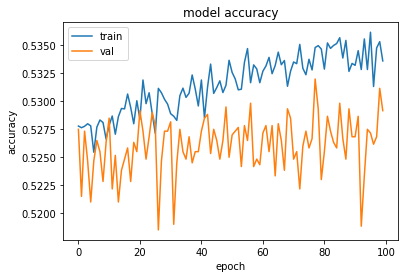

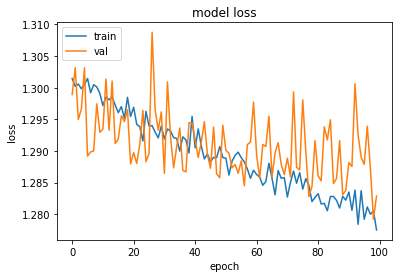

In [0]:
#학습 결과물 시각화
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
#Test set에 대해 전처리
test_set = pd.read_csv(data_in_path + 'test_regression_ascending.csv')
Id_list = test_set.pop('Id')
test_set = test_set.loc[:,'Product_Info_1':'Medical_Keyword_48']
def string2int(string):
  return ord(string[:1])+int(string[1:2])
test_set["Product_Info_2"] = test_set["Product_Info_2"].apply(lambda s: string2int(s))

In [0]:
#Kaggle에 제출하기 위한 csv파일 작성
import csv
with open('test_prediction_300.csv', 'w',encoding = 'cp949') as f:
  writer = csv.writer(f)
  writer.writerow(['Id','Response'])
  out = model.predict(test_set, batch_size = 16)
  for i in range(len(out)):
    writer.writerow([Id_list[i],int(np.where(max(out[i])==out[i])[0])+1])